In [2]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [5]:
x_MainFoil, y_MainFoil = numpy.loadtxt('MainFoil_N=100.csv', delimiter=',', unpack=True)
x_FlapFoil, y_FlapFoil = numpy.loadtxt('FlapFoil_N=100.csv', delimiter=',', unpack=True)

(-0.7, 0.5)

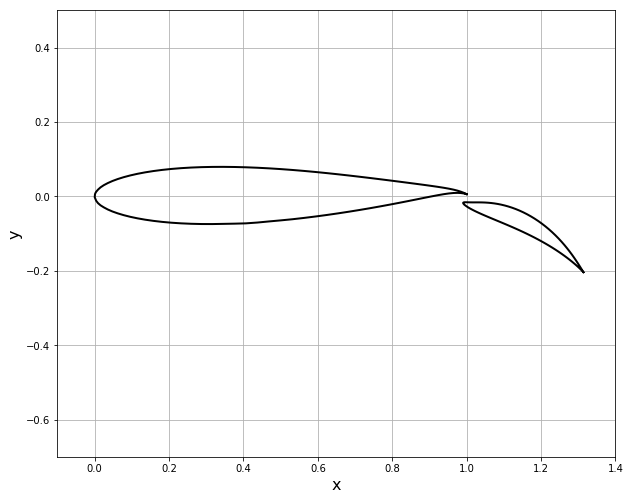

In [6]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_MainFoil, y_MainFoil, x_FlapFoil, y_FlapFoil, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.7, 0.5)

In [18]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)  
        
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
        
        self.sigma = 0.0  
        self.vt = 0.0  
        self.cp = 0.0 

In [25]:
x_ends = x_MainFoil
y_ends = y_MainFoil

N = 100
panels = numpy.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

In [7]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)

In [8]:
u_inf = 1.0                            
alpha = 0.0                            
freestream = Freestream(u_inf, alpha)  

In [9]:
def integral(x, y, panel, dxdz, dydz):
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [10]:
def build_matrix(panels):
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   math.cos(p_i.beta),
                                                   math.sin(p_i.beta))
    
    return A

def build_rhs(panels, freestream):
    b = numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    return b

In [26]:
A = build_matrix(panels)           
b = build_rhs(panels, freestream)